Crypto Momentum Trading
=======================

Inspiration: Huang et.al: Cryptocurrency Volume-Weighted Time Series Momentum
Data: Polarity Digital

**Notes**

* short term reversal (buying the worst 1d momentum works), fading the best also works but is worse

**Todo**

* feature crosscorrelation
* feature predicitve ability using linear models
* non linear models
* semiparametric models

**Research**

Wang et.al, The Training Set Delusion: Use ARIMA + GARCH to forecast BTC. Use Garman-Klass or Rogers-Satchell volatility measures.

Data Preparation
----------------

In [27]:
# prepare data and compute metrics

import duckdb
from glob import glob
import re
from os.path import basename
import polars as pl
import itertools as it

con = duckdb.connect(database=':memory:')

con.sql('''
    create or replace table coins as
    with stables as (
        select unnest(['dai','bsc-usd','busd','eurc','c1usd','susds','usd1','bfusd','fdusd','pyusd','rlusd','steakusdc','syrupusdc',
           'syrupusdt','tusd','usd0','usdai','usdb','usdc.e','usdc','usdd','usde','usdf',
           'usdg','usds','usdt','usdt0','usdtb','usdy']) as symbol
    ), raw as (
        select distinct on (ts, symbol)
            timestamp as ts,
            regexp_extract(filename, 'pd-data/(.+)\\.parquet', 1) as symbol,
            price as close,
            -- volume in USD
            total_volume as volume
        from read_parquet('pd-data/*.parquet', filename=true)
        where price is not null
          and total_volume > 0
        order by ts desc

    -- all non-stablecoins
    ), base as (
        select
            r.ts,
            r.symbol,
            r.close,
            r.volume
        from raw r
        where not exists (select 1 from stables s where s.symbol = r.symbol)
          and symbol is not null
    ), ocv as (
        select
            b.ts,
            b.symbol,
            b.close,
            
            -- crypto trades 24/7 yesterday's close = today's open
            bb.close as open,
            
            -- today's log return
            ln(b.close / open) as ret,

            b.volume,
            bb.volume as pvol
        from base b
        asof join base bb
            on b.symbol = bb.symbol
            and bb.ts < b.ts
        where b.ts - bb.ts <= interval '25 hour'
        
    -- lags used for various features
    ), params as (
        select unnest([1,2,3,4,5,10,15,20,30,60,120,200,300,400]) as lag

    -- time series price momentum
    ), features as (
        select 
            b.ts, 
            b.symbol,
            p.lag,
            b.ret,

            -- price momentum
            sum(b.ret) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            ) as mom,

            -- log return AR(1)
            corr(b.ret, bb.ret) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            ) as autocorr,

            -- log return volatility
            stddev(b.ret) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            ) as sigma,

            -- price level
            ln(b.open / mean(b.close) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            )) as level,

            -- volume level
            ln(b.volume / mean(b.volume) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            )) as vol

        from ocv b
        cross join params p
        asof join ocv bb
            on b.symbol = bb.symbol
            and bb.ts < b.ts
        where b.ts - bb.ts <= interval '25 hour'
         
    )
    select *
    from features;

-- cross-sectionally normalized feature
create or replace table cs_features as
with narrow as (
    unpivot coins
    on mom, autocorr, sigma, level, vol
    into
        name feature value value
), z as (
    select
        ts, lag, feature, ret,
        (value - mean(value) over csw) / stddev(value) over csw as zscore
    from narrow
    where value is not null and isfinite(value)
    window csw as (partition by ts, lag, feature)
)
pivot z
on feature
using any_value(zscore);

-- timeseries normalized feature
create or replace table ts_features as
with narrow as (
    unpivot coins
    on mom, autocorr, sigma, level, vol
    into
        name feature value value
), z as (
    select
        ts, lag, feature, ret,
        (value - mean(value) over tsw) / stddev(value) over tsw as zscore
    from narrow
    where value is not null and isfinite(value)
    window tsw as (partition by symbol, lag, feature)
)
pivot z
on feature
using any_value(zscore);
''')

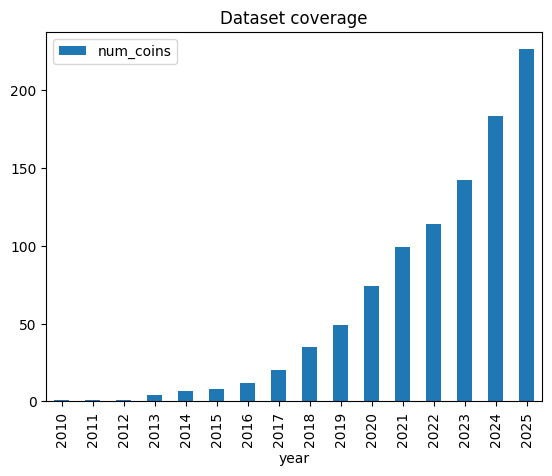

In [25]:
# coin data coverage

import matplotlib.pyplot as plt

df = con.sql('''
    select 
        year(ts) as year,
        count(distinct symbol) as num_coins
    from coins
    group by year
    order by year
''').df()

df.plot(x='year', y='num_coins', kind='bar', title='Dataset coverage')
plt.show()

Correlations with various features, lags and normalization
----------------------------------------------------------

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

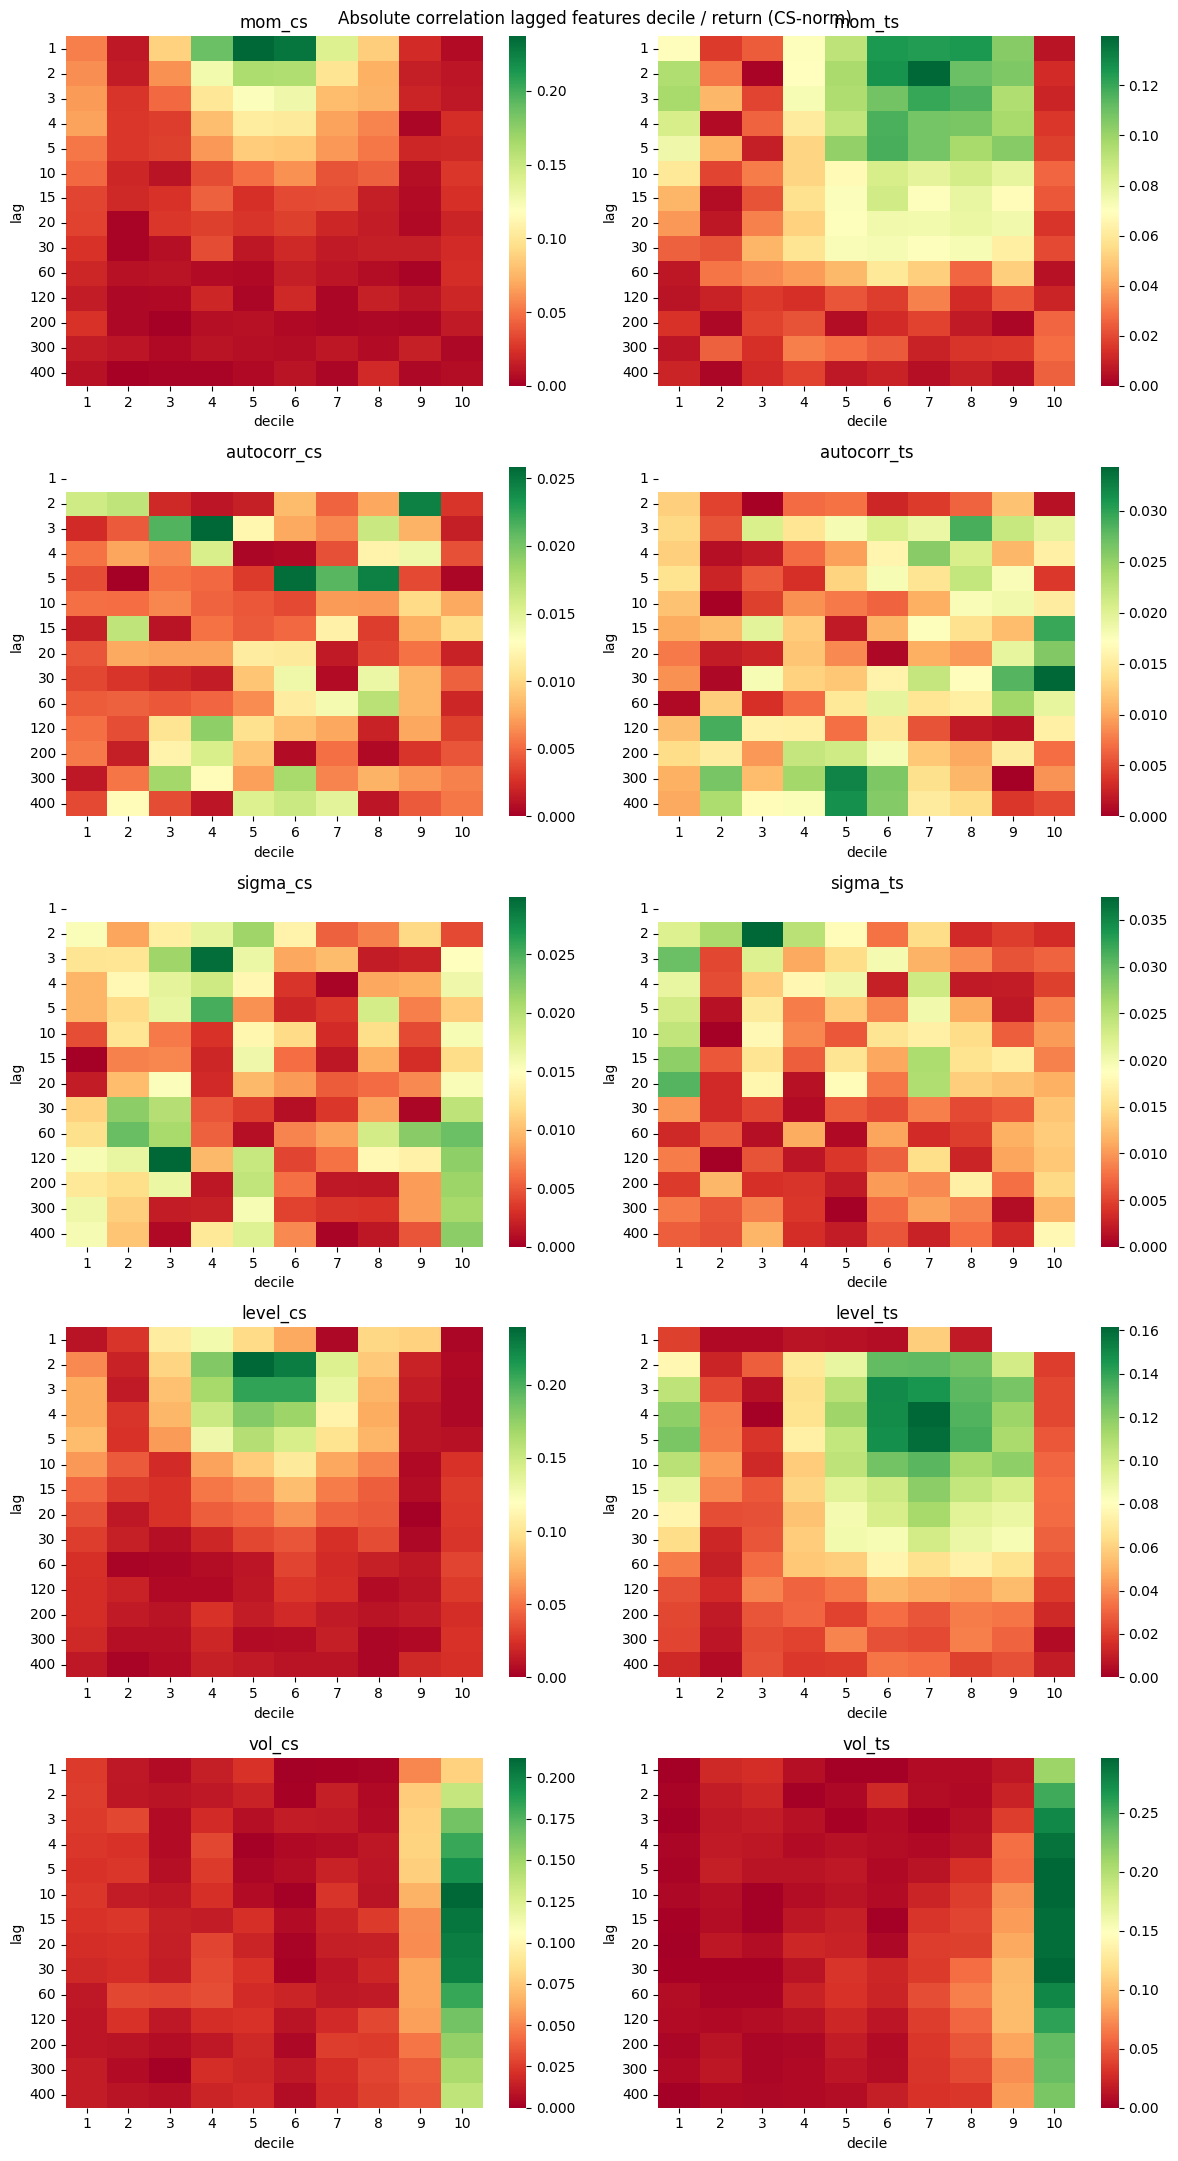

In [49]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = con.sql('''
    with cs as (
        unpivot cs_features
        on columns('(mom|autocorr|sigma|level|vol)') as '\\0_cs'
        into
            name feature value value
    ), ts as (
        unpivot ts_features
        on columns('(mom|autocorr|sigma|level|vol)') as '\\0_ts'
        into
            name feature value value
    ), deciles as (
        select
            lag, ret, feature, value,
            ntile(10) over (partition by ts, lag, feature order by value asc) as decile
        from (
            select * from cs
            union select * from ts
        )
    ), corr as (
        select lag, feature, decile, corr(ret, value) as corr
        from deciles
        where value is not null and isfinite(value)
        group by lag, decile, feature
    )
    pivot corr
    on feature
    using any_value(corr)
''').df()

feats = list(map(lambda p: f'{p[0]}_{p[1]}', it.product(['mom','autocorr','sigma','level','vol'], ['cs','ts'])))
fig, axes = plt.subplots(5, 2, figsize=(12, 22))
axes = axes.flatten().tolist()

for ax, feat in zip(axes, feats):
    sns.heatmap(
        np.abs(df.pivot(index='lag', columns='decile', values=feat)),
        cmap='RdYlGn',vmin=0,ax=ax)
    ax.set_title(feat)

while len(axes) > len(feats):
    fig.delaxes(axes.pop())
    
fig.suptitle('Absolute correlation lagged features decile / return (CS-norm)')
fig.tight_layout()
plt.show()

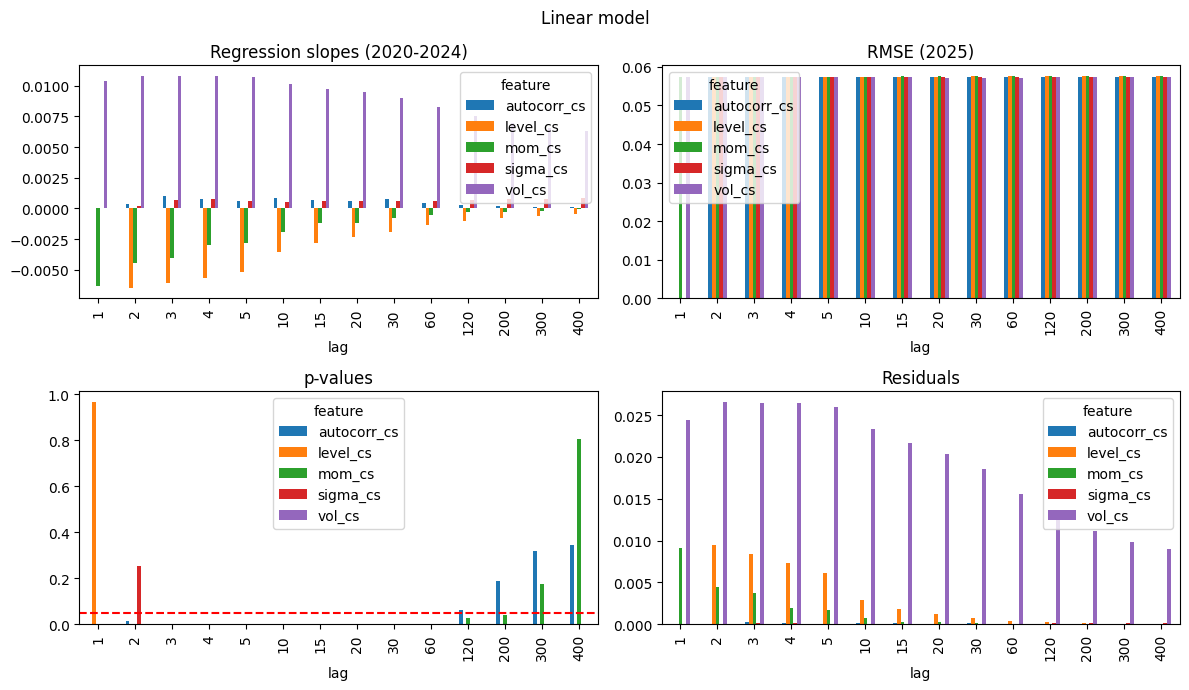

In [87]:
from scipy import stats

df = con.sql('''
    with cs as (
        unpivot cs_features
        on columns('(mom|autocorr|sigma|level|vol)') as '\\0_cs'
        into
            name feature value value
    ), ts as (
        unpivot ts_features
        on columns('(mom|autocorr|sigma|level|vol)') as '\\0_ts'
        into
            name feature value value
    ), model as (
        select
            lag, feature,
            regr_slope(ret, value) as b1,
            regr_intercept(ret, value) as b0,
            regr_r2(ret, value) as rsq,
            regr_count(ret, value) as n,
            corr(ret, value) as corr,
            case
                when n > 2 then (corr * sqrt(n - 2)) / sqrt(1 - power(corr, 2))
                else null
            end as t
        from (
            select * from cs
            union select * from ts
        )
        where year(ts) >= 2020 and year(ts) <= 2024
          and value is not null and isfinite(value)
        group by lag, feature
    )
    select
        f.lag, f.feature,
        l.b1, l.rsq, l.n, l.corr, l.t,
        sqrt(avg(power(f.ret - (l.b1 * f.value + l.b0), 2))) as rmse
    from cs f
    join model l on l.lag = f.lag and l.feature = f.feature
    where year(f.ts) = 2025
    group by f.lag, f.feature, l.b1, l.rsq, l.n, l.corr, l.t,
    order by f.lag, f.feature
''').df()


df['p'] = df.apply(lambda r: stats.t.sf(abs(r.t), r.n - 2) * 2, axis=1)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

df.pivot(index='lag',columns='feature',values='b1').plot(
    kind='bar', ax=axes[0,0],title='Regression slopes (2020-2024)')
df.pivot(index='lag',columns='feature',values='rmse').plot(
    kind='bar', ax=axes[0,1],title='RMSE (2025)')
df.pivot(index='lag',columns='feature',values='p').plot(
    kind='bar', ax=axes[1,0],title='p-values')
axes[1,0].axhline(y=0.05, color='red', linestyle='dashed')
df.pivot(index='lag',columns='feature',values='rsq').plot(
    kind='bar',title='Residuals', ax=axes[1,1])

plt.suptitle('Linear model')
plt.tight_layout()
plt.show()

In [ ]:
# vol weight allocation
# add mcap
# encode crossing as triangle wave 0.01 0.1 1 (bullish cross) 0.1 0.01 and negative on bearish
# try linear models
# different up down patterns (up up down) for example 
# sma/ema slope
# above ma and rising, vol above 20 sma and rising
 
duckdb.sql('''
create or replace table returns as
select
    year(ts) as year,
    symbol,
    lag,
    sum(ret) as ret
from momentum
where mom > 0
group by year, symbol, lag
''')

duckdb.sql('''
create or replace table cross_alpha as
select
    r.year,
    r.lag,
    avg(r.ret - b.ret) as ret
from returns r
join benchmark b
  on b.year = r.year
group by r.year, r.lag
''')